In [1]:
import cv2
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt
import torch
np.set_printoptions(threshold=np.inf)
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def masks2segment(m):
    #m for masks
    #for i in range(len(m)):
    segment_mask = np.zeros_like(masks[0]["segmentation"], dtype=np.uint8)

    for i in range(len(m)):
        tmp = m[i]["segmentation"]
        tmp.astype(np.uint8())
        tmp = tmp * (i+1)
        #print(tmp.shape,i,tmp.any())
        segment_mask = segment_mask + tmp
    return segment_mask

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"#"sam_vit_h_4b8939.pth"
model_type = "vit_b"#"vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [2]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [3]:
import cv2
import numpy as np
from skimage.segmentation import slic

# 定义全局变量
selected_masks = []
segments = None
image = None
superpixel_visualization = None

# 定义鼠标事件回调函数
def mouse_callback(event, x, y, flags, param):
    global selected_masks, segments, superpixel_visualization
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # 获取当前鼠标位置的超像素ID
        segment_id = segments[y, x]

        # 检查当前选择的超像素是否已经在已选择的mask中
        existing_mask_index = -1
        for i, mask in enumerate(selected_masks):
            if mask[segments == segment_id].any():
                existing_mask_index = i
                break

        if existing_mask_index >= 0:
            # 如果当前选择的超像素已经在已选择的mask中，取消选择
            selected_masks.pop(existing_mask_index)
        else:
            # 创建一个与超像素分割相同形状的空白掩码
            mask = np.zeros_like(segments, dtype=np.uint8)

            # 将选定的超像素的值设置为255，其余值保持为0
            mask[segments == segment_id] = 255

            # 将当前选择的mask保存到列表中
            selected_masks.append(mask)

        # 更新可视化结果
        update_visualization()

# 定义函数，用于更新可视化结果
def update_visualization():
    global selected_masks, segments, image, superpixel_visualization
    
    # 创建一个与图像相同形状的临时图像
    superpixel_visualization = image.copy()
    
    # 绘制超像素边界
    for segment_id in np.unique(segments):
        segment_mask = np.zeros_like(segments, dtype=np.uint8)
        segment_mask[segments == segment_id] = 255
        #contours, _ = cv2.findContours(segment_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        contours, _ = cv2.findContours(segment_mask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.findContours(segment_mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)#cv2.findContours(segment_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        cv2.drawContours(superpixel_visualization, contours, -1, (255, 0, 0), 2)

    # 叠加已选择的mask到可视化结果上
    for mask in selected_masks:
        superpixel_visualization[mask != 0] = [0, 255, 0]  # 将mask区域设置为绿色

    # 在窗口中显示可视化结果
    cv2.imshow('Superpixel Segmentation', superpixel_visualization)

# 读取图像
image = cv2.imread('im42_edit1.jpg')

# 使用SAM算法进行像素分割
#masks = mask_generator.generate(image)
masks = mask_generator_2.generate(image)


segments = masks2segment(masks)

# 创建窗口并注册鼠标回调函数
cv2.namedWindow('Superpixel Segmentation',cv2.WINDOW_NORMAL)
cv2.setMouseCallback('Superpixel Segmentation', mouse_callback)

# 初始化可视化结果
update_visualization()

# 进入主循环，等待用户操作
while True:
    key = cv2.waitKey(1)

    # 按下ESC键退出循环
    if key == 27:
        break

    # 按下空格键重置选择
    if key == ord(' '):
        selected_masks = []
        update_visualization()

# 清理资源
cv2.destroyAllWindows()


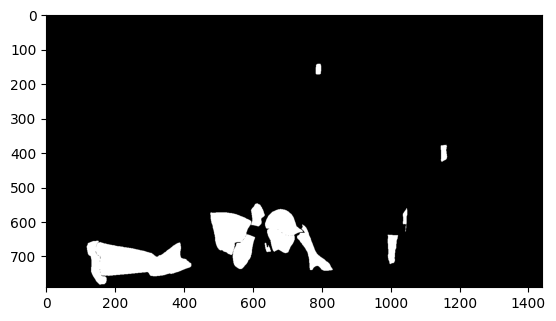

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有一个包含多个mask的列表selected_masks
# 假设每个mask对应于相同的图像，形状为(height, width)

# 创建一个新的图像，大小为(height, width)
combined_mask = np.zeros_like(selected_masks[0])

# 将所有的mask叠加到一起
for mask in selected_masks:
    combined_mask += mask

# 显示图像
plt.imshow(combined_mask, cmap='gray')

plt.show()


In [5]:
image = cv2.imread('comp_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

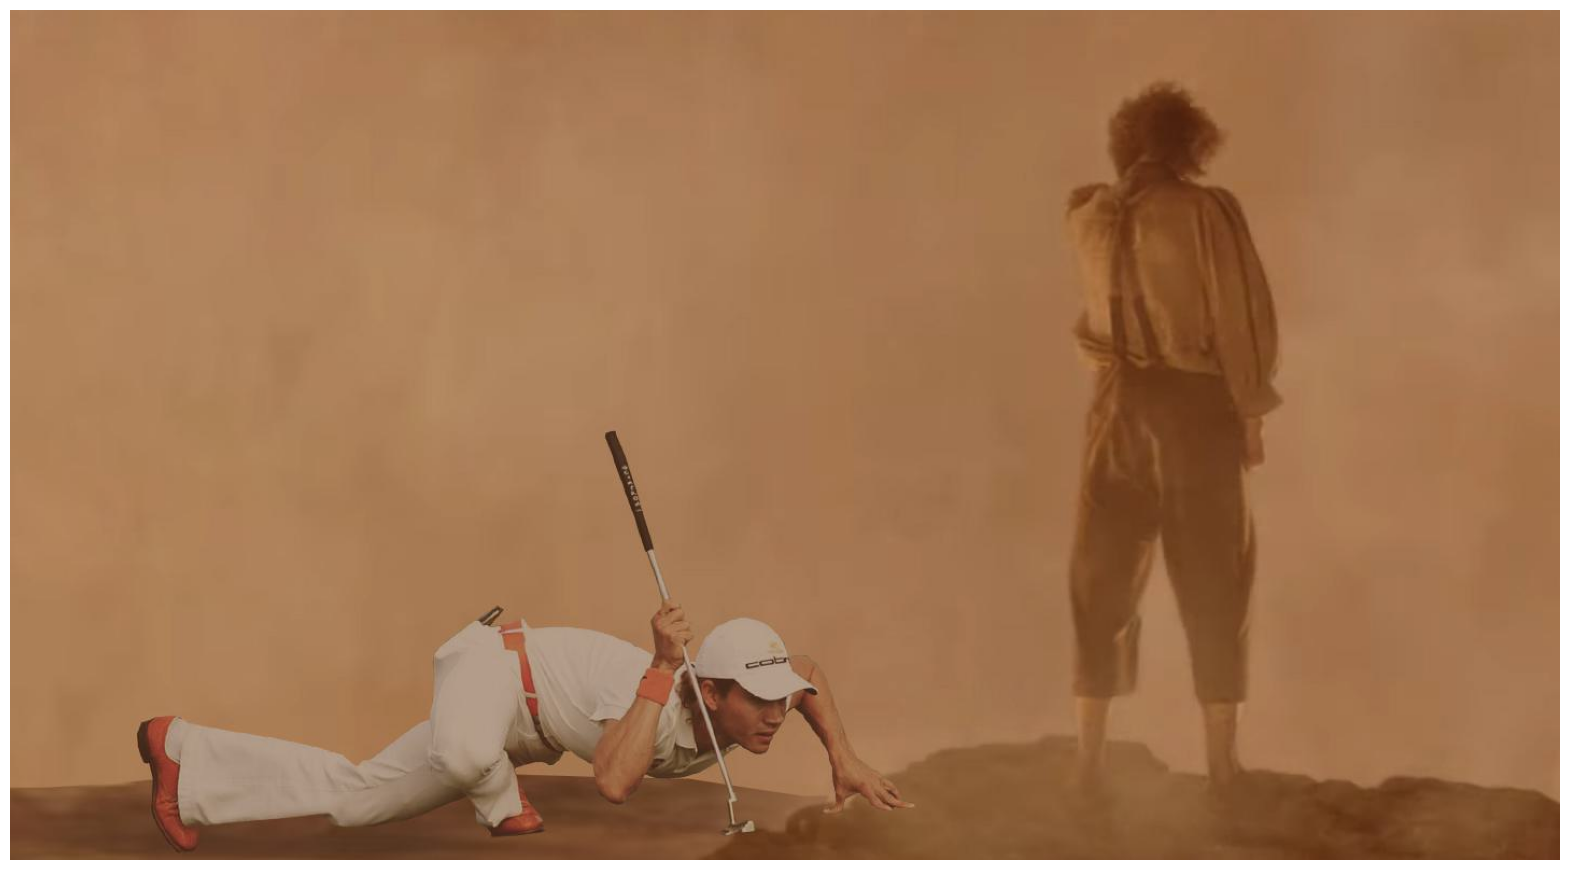

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation
To run automatic mask generation, provide a SAM model to the SamAutomaticMaskGenerator class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"#"sam_vit_h_4b8939.pth"
model_type = "vit_b"#"vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = mask_generator.generate(image)


In [9]:
print(len(masks))
print(masks[0].keys())

23
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


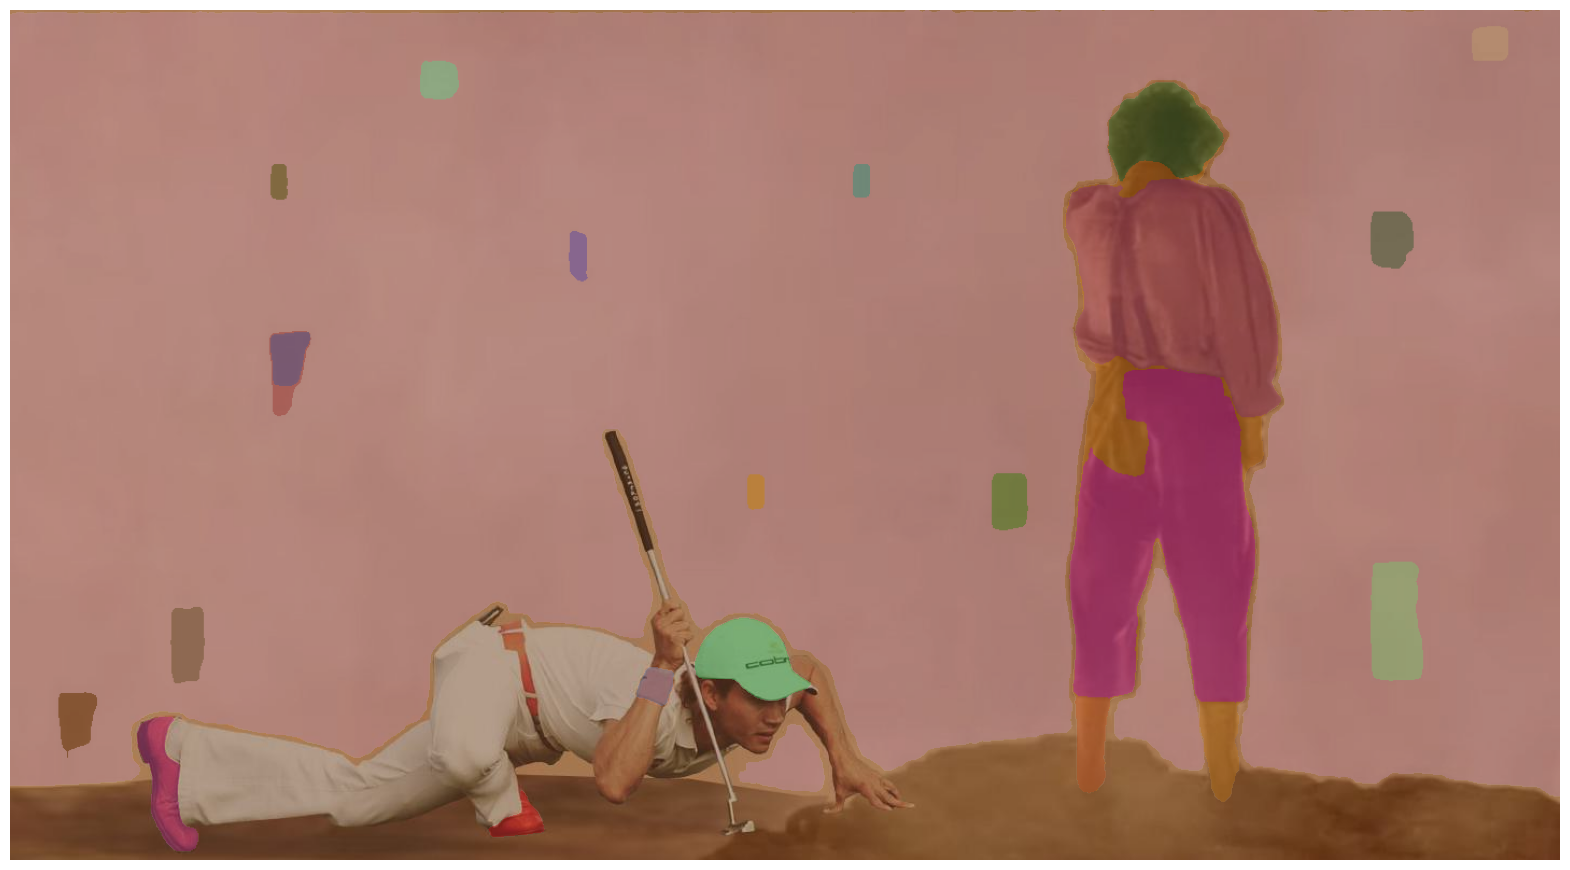

In [10]:

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [11]:
#masks[0]["segmentation"]


In [66]:
k = masks[0]["segmentation"]
k = k.astype(int)

In [69]:
k+k

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
len(masks)

23

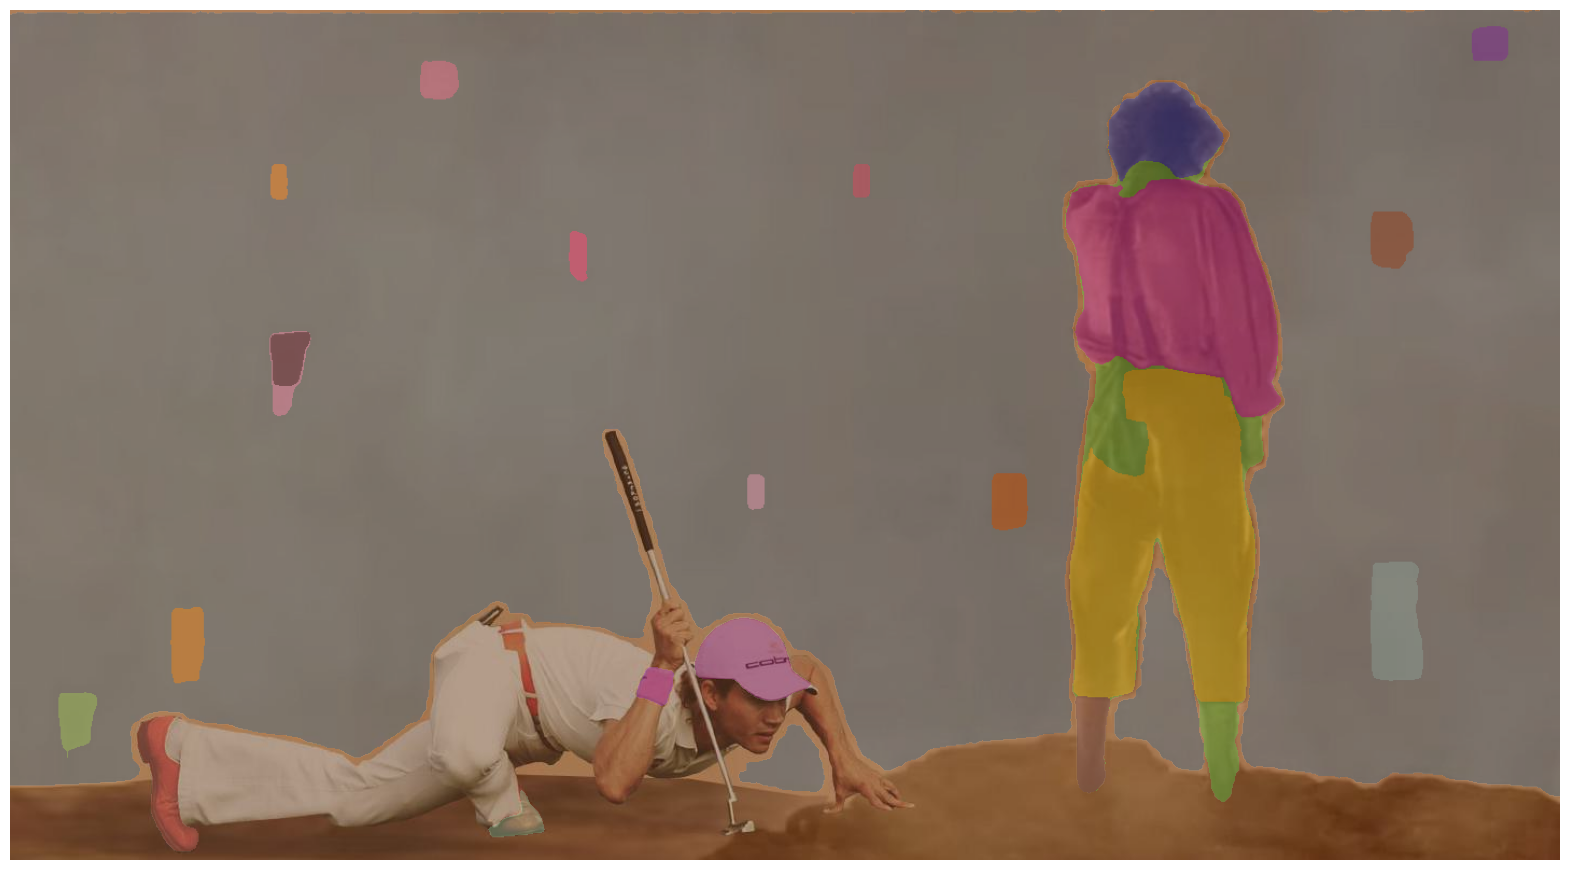

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 创建一个新的图像，大小为(height, width)
combined_mask = segment_mask#masks[0]["segmentation"]

# 显示图像
plt.imshow(combined_mask, cmap='gray')

plt.show()


NameError: name 'segment_mask' is not defined

In [ ]:
masks

In [58]:
selected_masks

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

In [60]:
from PIL import Image

# 将combined_mask转换为PIL图像对象
combined_image = Image.fromarray(combined_mask)#.astype(np.uint8) * 255)

# 保存为PNG图像文件
combined_image.save("combined_mask.png")


In [61]:

# 将image转换为PIL图像对象
#comp_image = Image.fromarray(image)#.astype(np.uint8) * 255)
comp_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# 保存为jpg图像文件
comp_image.save("comp_image.jpg")

#comp_image

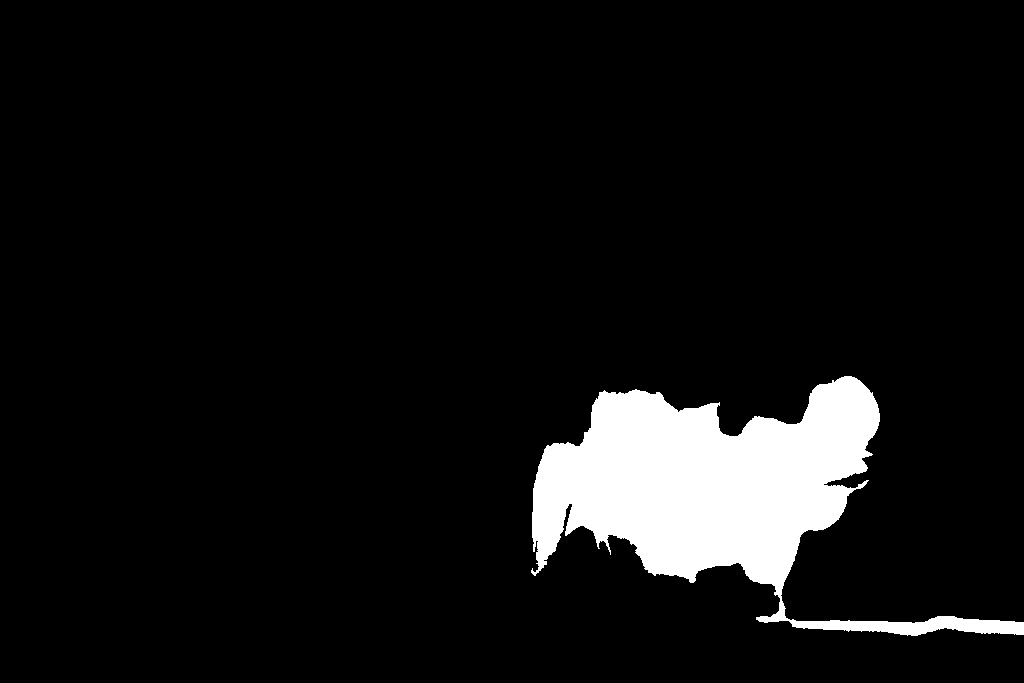

In [35]:
combined_image

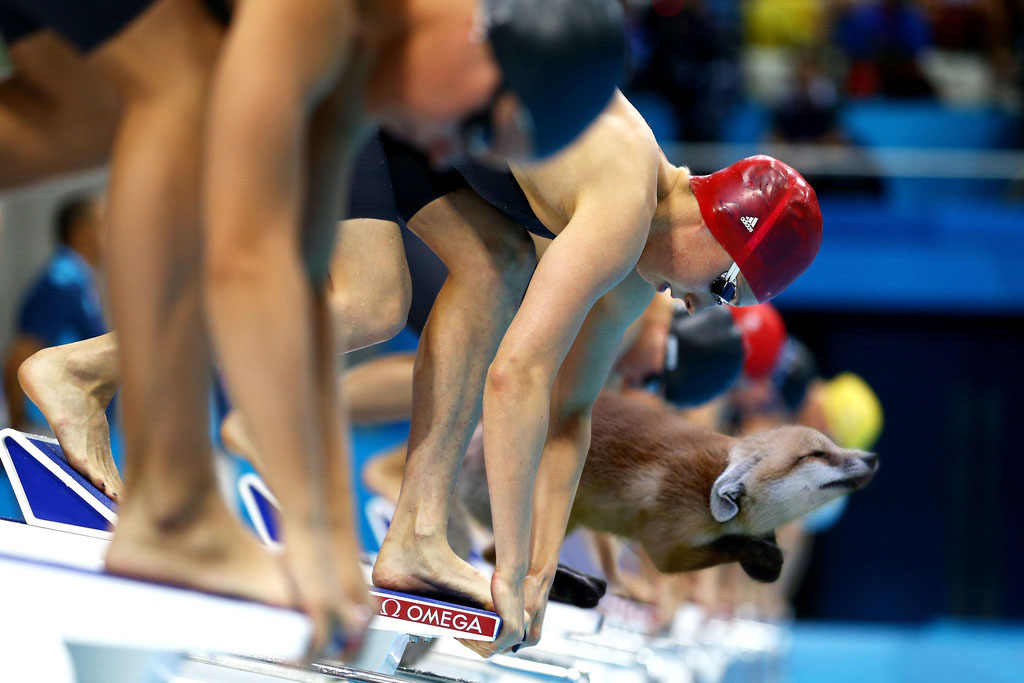

In [36]:
comp_image

In [7]:
import numpy as np

min_value = np.min(combined_mask)
max_value = np.max(combined_mask)

print("最小值:", min_value)
print("最大值:", max_value)


最小值: 0
最大值: 255
